# Flow Matching

This afternoon we're going to be working with the _same_ dataset as yesterday in Annalena's tutorial with binary black hole (BBH) merger, but... using a **continous normalizing flow** trained with the **flow matching loss** instead of the discrete normalizing flows from yesterday.

<img src="figures/Two_merging_black_holes.jpg.png"  width="400" >

Photo credit [ESA](https://www.esa.int/ESA_Multimedia/Images/2019/05/Two_merging_black_holes)

**Resources:** 
The data loading and evaluation code is the same as yday and comes from Annalena Kofler's [data_loading](https://github.com/odsl-team/genAI-Days/blob/main/01_normalizing_flows/data_loading.ipynb) notebook.  

Also, some of the code / notation from this notebook comes from the following excellent flow matching tutorials:
- Carol Cuesta's PALMS [tutorial](https://github.com/florpi/from-zero-to-generative-jax-tutorial/blob/main/2-generative.ipynb)
- Lukas Heinrich's flow matching notebooks: [1d](https://github.com/lukasheinrich/generative_models_examples/blob/main/flowmatching/FlowMatching1D.ipynb), [2d](https://github.com/lukasheinrich/generative_models_examples/blob/main/flowmatching/FlowMatching2D.ipynb)

### Table of Contents
1. [Preprocessing](#Preprocessing)
2. [Defining the velocity field](#velocity-NN)
3. [The Loss function + training](#velocity-NN)
4. [Evaluating the probability](#prob-eval)
5. [Samples from the flow](#sampling)
6. [BONUS: Movie of the posterior evolution](#movie)

Nicole Hartman 

ODSL GenAI Days

24 Sept 2024

In [68]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import corner

from torch.utils.data import Dataset, DataLoader, random_split

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# If running on Apple Silicon or CUDA is available, use the GPU.
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### Preprocessing 

Here we will again load and preprocess the data we generated in the notebook `data_generation.ipynb` and saved as `data/training_dataset.pkl`.

In [70]:
data_folder = '../01_normalizing_flows/data'
file_name = os.path.join(data_folder, 'dataset.pkl')

if not os.path.isfile(file_name):
    raise ValueError(f"File {file_name} does not exist, correct path or generate data set.")

with open(file_name, 'rb') as f:
    data = pickle.load(f)
print('Sucessfully loaded dataset with', len(data['hp']), 'waveforms.')

Sucessfully loaded dataset with 10000 waveforms.


Load in a pytorch Dataset and do the dataset preprocessing

In [71]:
class WaveformDataset(Dataset):
    
    def __init__(self, data):
        '''
        - data: As loaded from what we've saved from the 
                data_generation nb
        '''

        parameters = torch.FloatTensor(data['masses'])
    
        # Standardize masses for training
        self.parameters_mean = torch.mean(parameters, axis=0)
        self.parameters_std = torch.std(parameters, axis=0)
        
        parameters_standardized = (parameters - self.parameters_mean) / self.parameters_std
                
        '''
        Pre-process waveforms: 
        - truncate below f_min
        - re-package real and imaginary part
        - only use $h_+$ for simplicity
        '''
        hp = torch.tensor(data['hp'])
        f_min, T = data['f_min'], data['T']
        delta_f = 1/T
        
        lower_cut = int(f_min / delta_f)
        waveforms = torch.hstack([hp.real[:, lower_cut:], hp.imag[:, lower_cut:]])

        self.parameters = parameters_standardized
        self.waveforms = waveforms.float() # type-cast to torch.float32

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        '''
        Returns:
        params, t, cond_inputs (=data)
        [which we'll be calling x,t,y in the code]
        '''
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = torch.randn(size = signal.shape)
        data = signal + noise
        
        return params.to(device), data.to(device)

# Returns data in the form (params, data)
waveform_dataset = WaveformDataset(data)

### Split data into train and test dataset

In [72]:
# Split the dataset into training and test sets
num_samples = len(waveform_dataset)
train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 2. Defining the velocity field <a name="velocity-NN"></a>

### Conditional Normalizing Flow

**Step 1:** Set up a tiny MLP going from 2d + 1d + 1170d -> 2d (to learn the velocity field),
where the extra 1d comes from time being an input too.

In [73]:
import torch.nn as nn

In [74]:
param_dim  =waveform_dataset.parameters.shape[-1]
context_dim = waveform_dataset.waveforms.shape[-1] 

in_dim = param_dim + 1 +context_dim

In [75]:
hidden_dim = 512
activation_fct = nn.ELU()

# phi = nn.Sequential(nn.Linear(in_dim,hidden_dim),activation_fct,
#                     nn.Linear(hidden_dim,hidden_dim//2),activation_fct,
#                     nn.Linear(hidden_dim//2,hidden_dim//4),activation_fct,
#                     nn.Linear(hidden_dim//4,param_dim),
#                    ).to(device)


phi = nn.Sequential(nn.Linear(in_dim,hidden_dim),activation_fct,
                    nn.Linear(hidden_dim,hidden_dim),activation_fct,
                    nn.Linear(hidden_dim,hidden_dim),activation_fct,
                    nn.Linear(hidden_dim,param_dim),
                   ).to(device)

Other "tricks" that I could play:
- batch norm
- dropout
- residual connections

**Possible follow-up:** compress the vector $x$ before giving it to the network!
- E.g, w/ a Deep Set :)

**Check the input and output dimensionality**

In [76]:
for x,y in train_dataloader:
    break

In [78]:
x.shape,y.shape

(torch.Size([64, 2]), torch.Size([64, 1970]))

In [86]:
t = torch.rand(x.shape[0],1).to(device)
X_in = torch.concatenate([x,t,y],axis=1)
X_in.shape

torch.Size([64, 1973])

In [87]:
v_t = phi(X_in)
assert v_t.shape == x.shape

Sanity check passed :)

Text(0, 0.5, 'standardized $M_2$')

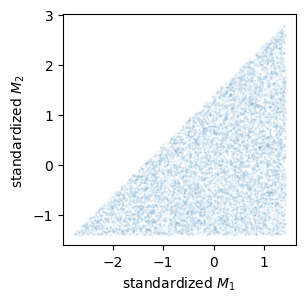

In [88]:
# What do the true masses look like?
plt.figure(figsize=(3,3))
plt.scatter(*waveform_dataset.parameters.T,1,marker='.',alpha=.1)
plt.xlabel('standardized $M_1$')
plt.ylabel('standardized $M_2$')

**Vizualize the velocity field before training**



Text(0, 0.5, 'M1')

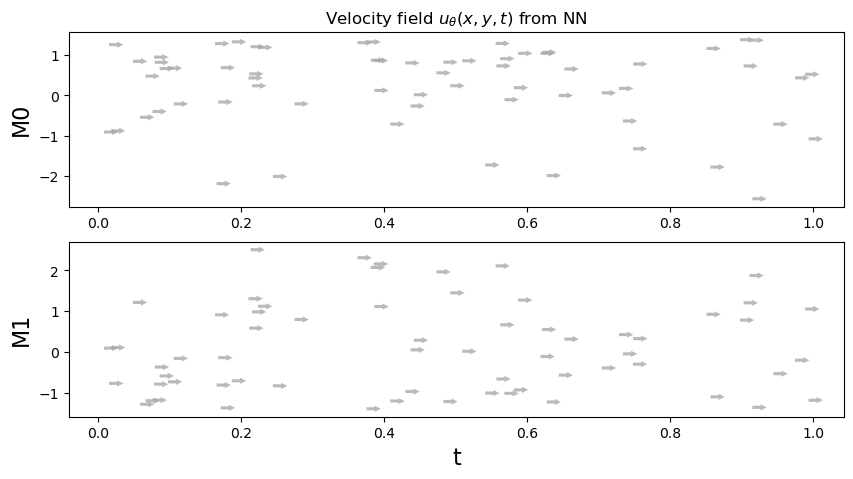

In [89]:
fig,ax = plt.subplots(2,1,figsize=(10,5))

kwargs = dict(angles='xy',scale_units='xy', scale=50,
              headwidth=2,headlength=2,headaxislength=2,
              width=.004,color='darkgrey',alpha=.8)
ax[0].quiver(t.squeeze().cpu(),x[:,0].detach().cpu(), np.ones(t.shape[0]), v_t[:,0].detach().cpu(),
           **kwargs)
ax[1].quiver(t.squeeze().cpu(),x[:,1].detach().cpu(), np.ones(t.shape[0]), v_t[:,1].detach().cpu(),
           **kwargs)

ax[1].set_xlabel('t',fontsize=16)
ax[0].set_title(r'Velocity field $u_\theta(x,y,t)$ from NN')

ax[0].set_ylabel('M0',fontsize=16)
ax[1].set_ylabel('M1',fontsize=16)


And, our loss function (in the next step) will be optimizing these arrows!

## 3. The Loss function + training <a name="velocity-NN"></a>

### Training

**Recap** The 3 step procedure
1. Express the velocity field w/ NN

$$\frac{d x_t}{dt} = v_\theta (x_t, t)$$
 
2. Use straight line approximation

$$x_t = (1-t) x_0  + tx _1 $$

3. Define the loss function

$$\mathcal{L} = \mathbb{E}_{t,x_0, x_1} \left[ ||v_\theta(x_t, t) - u(x_0 , x_1, t) ||^2 \right]$$

How does this picture get updated with the _conditional input_? The extra conditioning variable can just "come along for the ride" getting tacked on right after $t$.

But, it's very easy to see this is "safe" b/c this whold paradigm was built around conditional flow matching being a "safe" thing to do, now we're just additing conditioning on the parametrized velocity field instead of on the targets

**Conditional flow training:**

1. Express the velocity field w/ NN

$$\frac{d x_t}{dt} = v_\theta (x_t, t, \textcolor{red}{y})$$
 
2. Use straight line approximation

$$x_t = (1-t) x_0  + tx _1 $$

3. Define the loss function

$$\mathcal{L} = \mathbb{E}_{t,x_0, x_1} \left[ ||v_\theta(x_t, t, \textcolor{red}{y}) - u(x_0 , x_1, t) ||^2 \right]$$



**To do:** Separate the loss function calculation from the training loop

In [90]:
def get_losses(phi,x1,y1):
    '''
    For NN phi and given sample from the target dist
    calculate the MSE loss

    Inputs:
    - phi: The NN parametrizing the velocity field
    - x1: sample from the target (here GW masses)
    - t: time sample for eval the velocity field
    - y1: conditional inputs (GW signal)
    '''
    
    batch_size = x1.shape[0]
    
    # Sample x0 from a Gaussian and t from Uniform dist
    # Hints: torch.rand and torch.randn might 
    x0 = torch.randn(*x1.shape).to(device)
    t = torch.rand(batch_size)[:,None].to(device)

    # Little sanity check dimensions are as expected
    assert x0.shape == x1.shape
    assert len(t) == batch_size
    
    # Use x0 and x1 to construct xt
    xt = (1-t) * x0 + t * x1

    X_in = torch.concatenate([xt,t,y1],axis=1)
    v_t = phi(X_in) # NN velocity 
    
    u_t = x1 - x0 # target
    
    # Compute MSE loss  
    loss = (v_t - u_t) ** 2

    return loss

# Sanity check the inputs make sense
loss = get_losses(phi,x,y)
assert loss.shape == x.shape

In [91]:
# ?phi

In [92]:
# Training and test loops

def train_loop(dataloader, model, optimizer):

    model.train()
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (x,y) in enumerate(dataloader):

        loss = get_losses(model,x,y)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss

        
def test_loop(dataloader, model):

    model.eval()
    
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for x,y in dataloader:
            loss = get_losses(model,x,y)
            test_loss += loss.sum()

    test_loss = test_loss.item() / size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [93]:
optimizer = torch.optim.Adam(phi.parameters(), lr=1e-3, weight_decay=1e-6)

epochs = 500
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, phi, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, phi)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 1.666941  [    0/ 8000 samples]
Loss: 1.280122  [ 3200/ 8000 samples]
Loss: 1.155112  [ 6400/ 8000 samples]
Average loss: 2.6347
Test loss: 2.287460 

Epoch 2
-------------------------------
Loss: 1.162498  [    0/ 8000 samples]
Loss: 1.166463  [ 3200/ 8000 samples]
Loss: 0.960175  [ 6400/ 8000 samples]
Average loss: 2.2352
Test loss: 2.155921 

Epoch 3
-------------------------------
Loss: 1.029240  [    0/ 8000 samples]
Loss: 1.130535  [ 3200/ 8000 samples]
Loss: 1.013701  [ 6400/ 8000 samples]
Average loss: 2.0218
Test loss: 2.052080 

Epoch 4
-------------------------------
Loss: 0.796923  [    0/ 8000 samples]
Loss: 1.076526  [ 3200/ 8000 samples]
Loss: 0.884159  [ 6400/ 8000 samples]
Average loss: 1.8879
Test loss: 1.699571 

Epoch 5
-------------------------------
Loss: 0.872206  [    0/ 8000 samples]
Loss: 0.955187  [ 3200/ 8000 samples]
Loss: 0.998028  [ 6400/ 8000 samples]
Average loss: 1.7364
Test loss: 1.647936 

Epoch 6
-------

KeyboardInterrupt: 

In [94]:
import pandas as pd

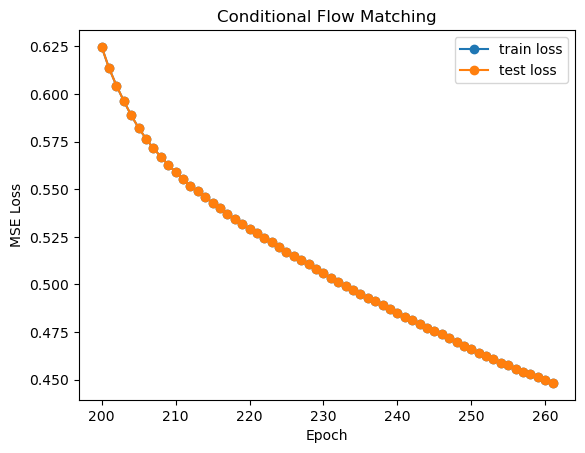

In [95]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, pd.Series(train_history).rolling(200).mean(), 
         '-o', label = 'train loss')
plt.plot(epochs, pd.Series(train_history).rolling(200).mean(), 
         '-o', label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Conditional Flow Matching')
plt.legend()
plt.show()

## 4. Evaluating the probability <a name="#prob-eval"></a>

**Amazing!!** How do these losses translate to the NLL which we were using for training yday?


OK, this is _just_ the same as the CNF that we had from this morning, the only difference is that we are training with a different loss function, but we can still _integrate_ the loss function to get the probability.

**TO DO:** [Enumerate the AIs]

In [96]:
class condCNF(nn.Module):
    """
    Copying over from `continuous_norm_flow` 
    and modifying it to be a conditional distribution 
    """
    def __init__(self, net):
        super().__init__()        
        self.phi = net
        
    def forward(self, t, states):
        z = states[0] # masses
        logp_z = states[1]
        cond_inpts = states[2] # GW signal
        
        batch_size = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            '''
            TO DO: Define the inputs that we'll use to evaluate the velocity field with
            '''
            X_in = torch.concatenate([z,t*torch.ones(batch_size,1),cond_inpts],axis=1)
            dz_dt = self.phi(X_in)
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batch_size, 1)

        return (dz_dt, dlogp_z_dt)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()

In [97]:
# Some global configs
adjoint=False

if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [98]:
func = condCNF(phi).to('cpu')

In [99]:
device='cpu'

In [100]:
for x,y in train_dataloader:
    break

In [101]:
'''
Clever workaround for some issues w/ CNF w/ additional inputs:
https://github.com/atong01/conditional-flow-matching/blob/main/examples/images/conditional_mnist.ipynb
'''
t0,t1=0,1
logp_diff_t1 = torch.zeros((x.shape[0],1)).float().to(device)

'''
TO DO: What are the bounds for the integration for density evaluation?
'''
z_t, logp_diff_t = odeint(
    lambda t,parital_state: func(t,(*parital_state,y)),
    (x,logp_diff_t1),
    # ... , # Fill in time here 
    torch.tensor([t1, t0]).float().to(device), # SOLN
    atol=1e-5,
    rtol=1e-5,
    method='dopri5',
)

Then to get the NLL, need to 

(1) combine the density of the samples under the X and Y

In [102]:
'''
TO DO: Define the base density
'''
p_z0 = torch.distributions.MultivariateNormal(
    # Your code here
    # loc=
    # covariance_matrix=
    loc=torch.zeros(param_dim).to(device), # soln
    covariance_matrix=torch.eye(param_dim).to(device) # soln
)

**Maybe I could turn this into a motivating Q** What are the dimensions of `z_t` and _which_ one should match the truth samples?

And have a little "assert" statement to check your understanding ;) 

In [103]:
log_prob = p_z0.log_prob(z_t[1]) - logp_diff_t[1].squeeze()
nll = - torch.mean(log_prob)
print(nll)

tensor(-1.5686, grad_fn=<NegBackward0>)


Amazing! How does this compare with the log likelihood that we got from the normalizing flows notebook from yesterday?

In [104]:
def eval_nll(dataloader):
    '''
    Goal: Calculate the NLL across the samples in the dataloader
    '''
    
    model.eval()

    size = len(dataloader.dataset)
    nll = 0

    logp_diff_t1 = torch.zeros((x.shape[0],1)).float().to(device)

    with torch.no_grad():
        for x,y in dataloader:

            # Integrate the batch backward in time
            z_t, logp_diff_t = odeint(
                                    lambda t,parital_state: func(t,(*parital_state,y)),
                                    (x,logp_diff_t1),
                                    torch.tensor([t1, t0]).type(torch.float32).to(device),
                                    atol=1e-5,
                                    rtol=1e-5,
                                    method='dopri5',
                                )

            # Calulate the log probability
            log_prob_i = p_z0.log_prob(z_t[1]) - logp_diff_t[1].squeeze()
            nll -= torch.sum(log_prob)
            
    nll = nll.item() / size
    
    return nll

## 5. Vizualizing samples from the flow <a name="sampling"></a>

**Vizualize the samples:** Need to integrate in the opposite direction

In [105]:
noise = torch.randn(x.shape).float().to(device)
logp_diff_t0 = torch.zeros((x.shape[0],1)).float().to(device)

z_samples, logp_diff_t = odeint(
    lambda t,parital_state: func(t,(*parital_state,y)),
    (noise,logp_diff_t0),
    torch.tensor([t0,t1]).float().to(device),
    atol=1e-5,
    rtol=1e-5,
    method='dopri5',
)

Following the mpl [docs](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py) for the fancy plot layout :)

In [107]:
t = torch.rand(x.shape[0],1).to(device)
X_in = torch.concatenate([x,t,y],axis=1)
v_t = phi(X_in)

Text(0, 0.5, 'M1')

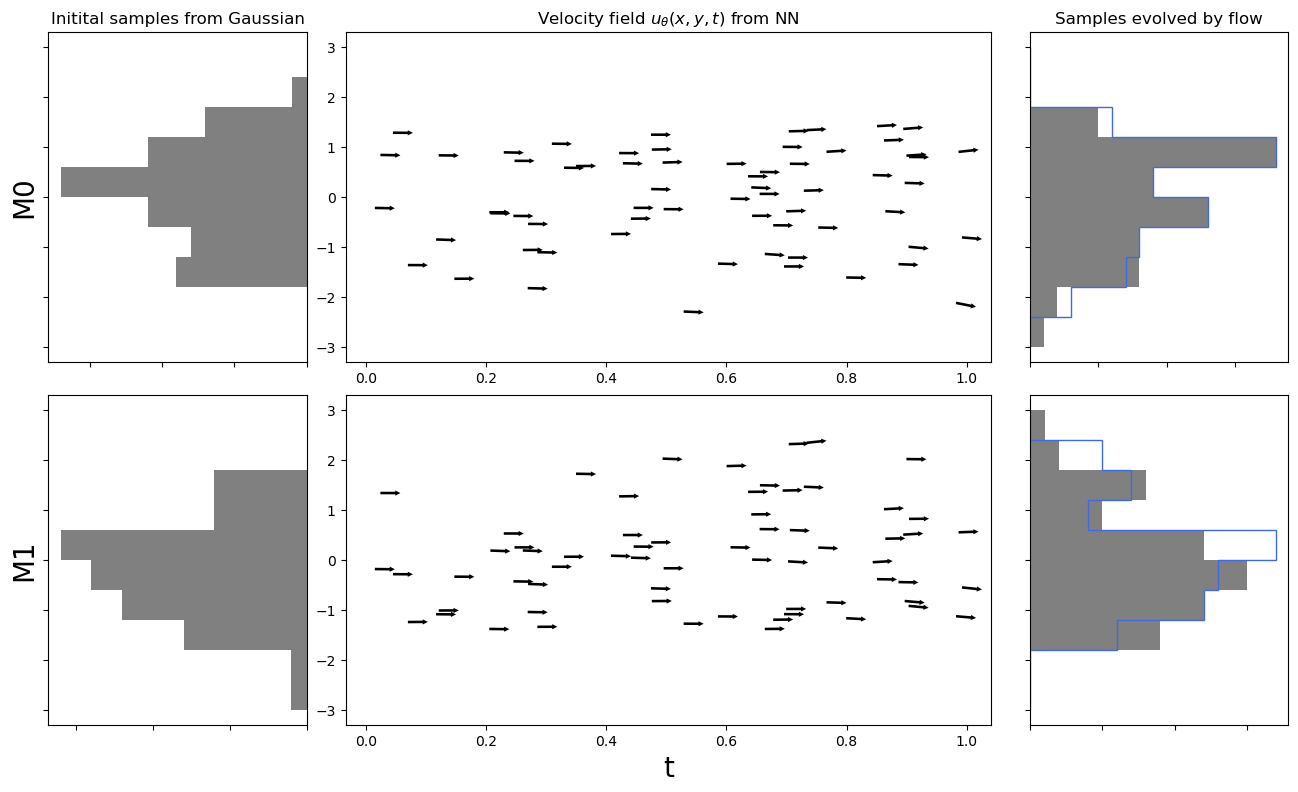

In [109]:
fig = plt.figure(figsize=(16,9))

# Add a gridspec with 3 rows and two columns and 
# a ratio of 1 to 3 to 1 between along the horizontal and
# 1 to 1 on the verical
gs = fig.add_gridspec(2, 3,  width_ratios=(1, 2.5, 1), height_ratios=(1, 1),
                      wspace=0.1, hspace=0.1
                     )
# Create the Axes.
ax11 = fig.add_subplot(gs[1,1])
ax10 = fig.add_subplot(gs[1,0],sharey=ax11)
ax12 = fig.add_subplot(gs[1,2],sharey=ax11)

ax01 = fig.add_subplot(gs[0,1],sharex=ax11)
ax00 = fig.add_subplot(gs[0,0],sharey=ax01)
ax02 = fig.add_subplot(gs[0,2],sharey=ax01)

kwargs = dict(angles='xy',scale_units='xy', scale=30,
              headwidth=2,headlength=2,headaxislength=2,
              width=.004)
ax01.quiver(t.squeeze().cpu(),x[:,0].detach().cpu(), np.ones(t.shape[0]), v_t[:,0].detach().cpu(),
           **kwargs)
ax11.quiver(t.squeeze().cpu(),x[:,1].detach().cpu(), np.ones(t.shape[0]), v_t[:,1].detach().cpu(),
           **kwargs)

ax11.set_xlabel('t',fontsize=20)

'''
Draw the samples @ the beginning + end of the trajectory.
These are the samples we'll transform to plot the posterior
'''
z = torch.randn((t.shape[0],param_dim)) 

# Turn off the tick labels bc we're sharing the mass axis anyways
for axi in [ax00,ax02,ax10,ax12]:
    axi.tick_params(axis="x", labelbottom=False)
    axi.tick_params(axis="y", labelleft=False)

kwargs = dict(range=(-3,3),orientation='horizontal')
ax00.hist(z[:,0], color='grey', **kwargs)
ax10.hist(z[:,1], color='grey', **kwargs)

# Plot the evolution of these samples thru the velocity field
ax02.hist(z_samples[1,:,0].detach().numpy(), color='grey', **kwargs)
ax12.hist(z_samples[1,:,1].detach().numpy(), color='grey', **kwargs)

ax02.hist(x[:,0].detach().cpu(),color='royalblue',histtype='step', **kwargs)
ax12.hist(x[:,1].detach().cpu(),color='royalblue',histtype='step', **kwargs)

# Let the bottom of the histogram align with the left edge of the velocity plot
# https://stackoverflow.com/questions/67685927/how-to-create-a-horizontal-histogram-the-other-way-around
ax00.set_xlim(list(ax00.get_xlim())[::-1])
ax10.set_xlim(list(ax10.get_xlim())[::-1])

ax00.set_title('Initital samples from Gaussian')
ax01.set_title(r'Velocity field $u_\theta(x,y,t)$ from NN')
ax02.set_title('Samples evolved by flow')

ax00.set_ylabel('M0',fontsize=20)
ax10.set_ylabel('M1',fontsize=20)


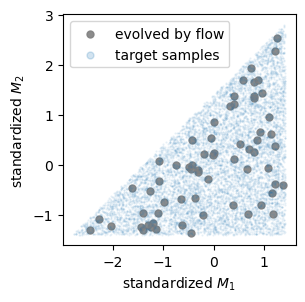

In [115]:
plt.figure(figsize=(3,3))
plt.scatter(*z_samples[1].T.detach().cpu(),100,marker='.',alpha=.9,color='grey',label='evolved by flow')
# plt.scatter(*z_samples[0].T.detach().cpu(),100,marker='.',alpha=.9,color='r',label='noise')

plt.scatter(*waveform_dataset.parameters.T,1,marker='.',alpha=.1)
plt.scatter([],[],100,color='C0',marker='.',alpha=.2,label='target samples') # Let the label be a bit bigger

plt.xlabel('standardized $M_1$')
plt.ylabel('standardized $M_2$')
plt.legend()

### Visualize posteriors

tensor([33.7607, 25.6152])


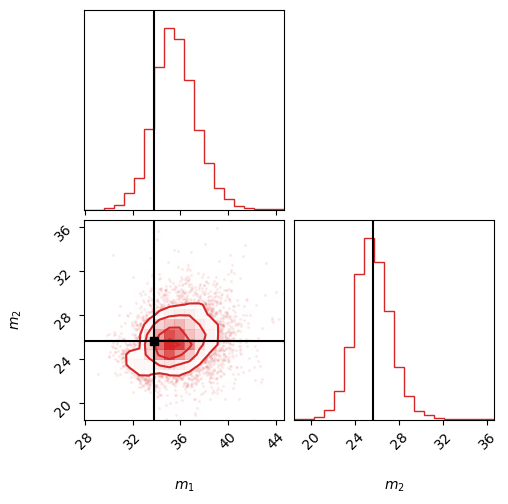

tensor([72.9030, 30.2543])


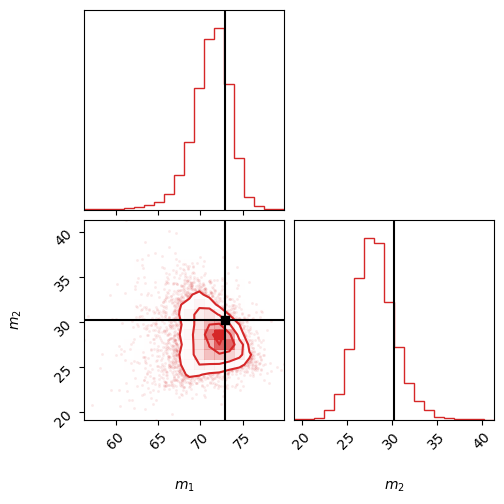

tensor([46.6914, 27.0422])


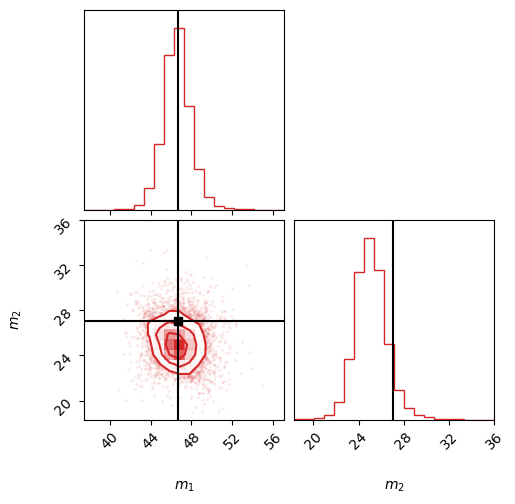

In [126]:
num_posteriors = 3
num_eval_samples = 10_000

func.eval()

for n in range(num_posteriors):

    with torch.no_grad():
    
        test_x, test_y = test_dataset[n]
       
        # Sample the posterior
        test_y = test_y.expand(num_eval_samples, *test_y.shape)
        
        noise = torch.randn((num_eval_samples, param_dim)).float().to(device)
        logp_diff_t0 = torch.zeros((num_eval_samples,1)).float().to(device)
        
        z_samples, logp_diff_t = odeint(
            lambda t,parital_state: func(t,(*parital_state,test_y)),
            (noise,logp_diff_t0),
            torch.tensor([t0,t1]).float().to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        pred_samples = z_samples[1]

        # Undo the standardization
        parameters_mean = waveform_dataset.parameters_mean
        parameters_std = waveform_dataset.parameters_std
        
        pred_samples = parameters_std * pred_samples + parameters_mean
        truth = parameters_std * test_x + parameters_mean
        print(truth)
    
        # Plot
        corner.corner(pred_samples.cpu().numpy(), 
                      truths=truth.cpu().numpy(), 
                      labels=['$m_1$', '$m_2$'],
                      color='C3',truth_color='k'
                     )
        plt.show()

## 6. BONUS: Movie of the posterior evolution <a name="movie"></a>

OK, let's extend the code to make one of these corner plots a MOVIE!!

In [130]:
import matplotlib as mpl

In [132]:
n=0 # Can change for whichever event you like  (!)

viz_timesteps=11

timesteps = torch.linspace(t0, t1, viz_timesteps).float()

with torch.no_grad():

    test_x, test_y = test_dataset[n]
   
    # Sample the posterior
    test_y = test_y.expand(num_eval_samples, *test_y.shape)
    # pred_samples = model.sample(1, test_y).squeeze(1).cpu().numpy()

    noise = torch.randn((num_eval_samples, param_dim)).float().to(device)
    logp_diff_t0 = torch.zeros((num_eval_samples,1)).float().to(device)
    
    z_samples, logp_diff_t = odeint(
        lambda t,parital_state: func(t,(*parital_state,test_y)),
        (noise,logp_diff_t0),
        timesteps,
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

# Undo the standardization
truth = parameters_std * test_x.cpu().numpy() + parameters_mean
truth

In [157]:
import glob
from PIL import Image

In [170]:
# Make the movie
cmap = mpl.colormaps['coolwarm']
colors = cmap( timesteps )

results_dir = "./figures/tmp"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for i,ti,ci in zip(range(viz_timesteps),timesteps,colors):

    pred_samples = z_samples[i]
    pred_samples = parameters_std * pred_samples + parameters_mean
    
    corner.corner(pred_samples.detach().numpy(), truths=truth.numpy(), labels=['$m_1$', '$m_2$'],
                  color=ci,truth_color='k')
    fig=plt.gcf()
    fig.suptitle(f't={ti:.1f}: '+'$p_t(x) = F_{\sharp t}p_0(x)$',color=ci)
    plt.savefig(os.path.join(results_dir, f"fm-posterior-{n}-{ti}.jpg"),
                       pad_inches=0.2, bbox_inches='tight')
    plt.close()

img, *imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(results_dir, f"fm-posterior-{n}-*.jpg")))]
img.save(fp=f"figures/fm-posterior-{n}.gif", format='GIF', append_images=imgs, save_all=True, duration=250, loop=0)
os.system(f'rm -rf {results_dir}')

0

Look in the `figures` directory to see your movie!!